<a href="https://colab.research.google.com/github/ddv246/DSBA-Project/blob/master/Taxi_Demand_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predicting New York City Yellow Taxi Demand**

## **Business Problem:**

---
In the New York city, people use taxi at a much higher frequency than most places. Instead
of booking customers by phone ahead of time, there is still a majority of New York taxi
drivers that pick up passengers on street. However, as per recent studies, Taxi patronage
has considerably declined since 2011 due to competition from
rideshare
services like Uber,
Lyft etc. The ability to predict taxi ridership could present valuable insights to such taxi
dispatchers that would in turn help them in making important decisions that could revive
their profit margin - such as how to position cabs where they are most needed, how many
taxis to dispatch, and how ridership varies over time. Our project focuses on **predicting the
number of taxi pickups** given a one-hour time window and a location within New York City.


# **Use Case Scenario:**

---

For any given location in New York City, our goal is to predict the number of pickups in that
given location at particular time interval. Some location require more taxis at a particular
time than other locations due to their proximity to offices, schools, hospitals etc. With the
competition that the Yellow Taxi drivers are facing due to the advent of apps like Uber and
Lyft, we propose a solution that will help them predict the taxi demand in a particular area.
The prediction result can be transferred to the taxi drivers via Mobile app’s, and they can
subsequently move to the locations where the predicted pickups are higher and so they can
profit more than they normally would.


# **Data Information:**

---

**Source of Data:** https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page 

Here, we have used October 2015 data.

**Information on Taxi:**

**Yellow Taxi: Yellow Medallion Taxicabs**

Trips made by New York City’s iconic yellow taxis have been recorded and provided to the TLC
since 2009. Yellow taxis are traditionally hailed by signaling to a driver who is on duty and seeking
a passenger (street hail). The pickups are not pre-arranged.
Yellow taxis are the only vehicles permitted to respond to a street hail from a passenger in all five
boroughs. 


In [95]:
#If opening in colab run this cell
!git clone https://github.com/ddv246/DSBA-Project
%cd DSBA-Project/YellowTaxi

Cloning into 'DSBA-Project'...
remote: Enumerating objects: 72, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 72 (delta 33), reused 23 (delta 5), pack-reused 0
Unpacking objects: 100% (72/72), done.
/content/DSBA-Project/YellowTaxi/DSBA-Project/YellowTaxi


In [96]:
!pip install gpxpy

In [0]:
#Importing Libraries
# pip3 install graphviz
#pip3 install dask
#pip3 install toolz
#pip3 install cloudpickle
# https://www.youtube.com/watch?v=ieW3G7ZzRZ0
# https://github.com/dask/dask-tutorial
# please do go through this python notebook: https://github.com/dask/dask-tutorial/blob/master/07_dataframe.ipynb
import dask.dataframe as dd#similar to pandas

import pandas as pd#pandas to create small dataframes 

# pip3 install foliun
# if this doesnt work refere install_folium.JPG in drive
import folium #open street map

# unix time: https://www.unixtimestamp.com/
import datetime #Convert to unix time

import time #Convert to unix time

# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays

# matplotlib: used to plot graphs
import matplotlib
# matplotlib.use('nbagg') : matplotlib uses this protocall which makes plots more user intractive like zoom in and zoom out
matplotlib.use('nbagg')
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  

# this lib is used while we calculate the stight line distance between two (lat,lon) pairs in miles
import gpxpy.geo #Get the haversine distance

from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os

# download migwin: https://mingw-w64.org/doku.php/download/mingw-builds
# install it in your system and keep the path, migw_path ='installed path'
mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-5.3.0-posix-seh-rt_v4-rev0\\mingw64\\bin'
os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']

# to install xgboost: pip3 install xgboost
# if it didnt happen check install_xgboost.JPG
import xgboost as xgb

# to install sklearn: pip install -U scikit-learn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

In [0]:
#import glob


#all_files1 = []
#for name in glob.glob('YellowTaxi/*'):
 #   all_files1.append(name)

#li = []


#for filename in all_files1:
 #   df = pd.read_csv(filename, index_col=None, header=0)
  #  li.append(df)

#frame = pd.concat(li, axis=0, ignore_index=True)



In [98]:
df=pd.read_csv("2015_sample.csv")
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2015-10-01 00:00:00,2015-10-01 00:05:48,1,1.10,-73.935516,40.761238,1,N,-73.944351,40.754578,2,6.00,0.5,0.5,0.00,0.0,0.3,7.30
1,2,2015-10-01 00:00:00,2015-10-01 00:00:00,1,7.68,-73.989937,40.743439,1,N,-73.986687,40.689129,2,27.50,0.0,0.5,0.00,0.0,0.3,28.30
2,2,2015-10-01 00:00:00,2015-10-01 00:00:00,2,2.53,-73.987328,40.720020,1,N,-73.999084,40.744381,1,12.50,0.0,0.5,2.00,0.0,0.3,15.30
3,2,2015-10-01 00:00:00,2015-10-01 00:00:00,0,1.20,-73.953758,40.743385,5,N,-73.930008,40.736622,2,25.26,0.0,0.5,0.00,0.0,0.3,26.06
4,1,2015-10-01 00:00:01,2015-10-01 00:16:19,1,3.80,-73.984016,40.755222,1,N,-73.959869,40.801323,1,15.50,0.5,0.5,3.00,0.0,0.3,19.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99994,2,2015-10-01 09:33:05,2015-10-01 09:55:19,1,5.00,-73.960625,40.761410,1,N,-74.002640,40.728294,1,20.50,0.0,0.5,4.26,0.0,0.3,25.56
99995,1,2015-10-01 09:33:06,2015-10-01 09:46:03,1,1.00,-74.008865,40.715946,1,N,-73.997917,40.720467,1,9.00,0.0,0.5,2.90,0.0,0.3,12.70
99996,1,2015-10-01 09:33:06,2015-10-01 09:57:39,1,2.60,-73.981049,40.729874,1,N,-73.991631,40.754829,1,16.00,0.0,0.5,3.36,0.0,0.3,20.16
99997,2,2015-10-01 09:33:06,2015-10-01 09:52:57,5,0.99,-73.975304,40.759300,1,N,-73.964859,40.769749,1,13.00,0.0,0.5,2.76,0.0,0.3,16.56


In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   VendorID               99999 non-null  int64  
 1   tpep_pickup_datetime   99999 non-null  object 
 2   tpep_dropoff_datetime  99999 non-null  object 
 3   passenger_count        99999 non-null  int64  
 4   trip_distance          99999 non-null  float64
 5   pickup_longitude       99999 non-null  float64
 6   pickup_latitude        99999 non-null  float64
 7   RatecodeID             99999 non-null  int64  
 8   store_and_fwd_flag     99999 non-null  object 
 9   dropoff_longitude      99999 non-null  float64
 10  dropoff_latitude       99999 non-null  float64
 11  payment_type           99999 non-null  int64  
 12  fare_amount            99999 non-null  float64
 13  extra                  99999 non-null  float64
 14  mta_tax                99999 non-null  float64
 15  ti

# **Problem Formualtion**

---



Given a region and a 10 min interval, we have to predict pickups.


*  How to break up the NYC into regions?
*  Every region of NYC has to be broken up into 10 min interval.

We already know, about the pickup at time ‘t’, we will predict the pickup at time ‘t+1’ in the same region.



# **Features in Dataset:** 

---
Field Name | 	Description
--- | ---
**VendorID** | A code indicating the TPEP provider that provided the record. 
             | 1= Creative Mobile Technologies, LLC; 2= VeriFone Inc
**tpep_pickup_datetime** | The date and time when the meter was engaged. 
**tpep_dropoff_datetime**| The date and time when the meter was disengaged. 
**Passenger_count** | The number of passengers in the vehicle. This is a driver-entered value
**Trip_distance**  | The elapsed trip distance in miles reported by the taximeter.
**PULocationID** | TLC Taxi Zone in which the taximeter was engaged
**DOLocationID** | TLC Taxi Zone in which the taximeter was disengaged
**RateCodeID** | The final rate code in effect at the end of the trip.
**Store_and_fwd_flag** | This flag indicates whether the trip record was held in  vehicle memory before sending to the vendor,
| because the vehicle did not have a connection to the server.
**Payment_type** | A numeric code signifying how the passenger paid for the trip. 
**Fare_amount** | The time-and-distance fare calculated by the meter.
**Extra** | Miscellaneous extras and surcharges. Currently, this only includes
      |the $0.50  and  $1 rush hour and overnight charges. 
**Improvement_surcharge** |$0.30 improvement surcharge assessed trips at the flag drop. The improvement surcharge began being levied in 2015.
**Tip_amount** |Tip amount – This field is automatically populated for credit card tips.Cash tips are not included.
**Tolls_amount** |Total amount of all tolls paid in trip.
**Total_amount** |The total amount charged to passengers. Does not include cash tips.
**MTA_Tax** | 50 cent MTA tax that is automatically triggered based on the metered rate in use.




## **DATA CLEANING**
As a process of Data Cleaning and univariate analysis of the data, all errorneous and outlier points will be removed. Some of them listed below,



1.   **Checking Uniqueness of Vendor_ID.**
2.   **Checking if drop off time is earlier than pick up time.**

1.   **Checking if passenger_count is less than 0.**
2.   **Checking if Trip distance is less than 0.1 miles.**

1.   **Checking if Payment type is invalid.**
2.   **Checking if Latitute and Longtitude fall within NYC.**







In [100]:
df.isnull().sum()


VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
pickup_longitude         0
pickup_latitude          0
RatecodeID               0
store_and_fwd_flag       0
dropoff_longitude        0
dropoff_latitude         0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
dtype: int64

#### **Dropping NA**

In [0]:
df=df.dropna()


#### **Deleting unnecessary columns**

In [0]:
del df['RatecodeID']

In [0]:
del df ['store_and_fwd_flag']

In [0]:
df.drop(df[df.trip_distance ==0.00].index, inplace=True)

In [105]:
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2015-10-01 00:00:00,2015-10-01 00:05:48,1,1.10,-73.935516,40.761238,-73.944351,40.754578,2,6.00,0.5,0.5,0.00,0.0,0.3,7.30
1,2,2015-10-01 00:00:00,2015-10-01 00:00:00,1,7.68,-73.989937,40.743439,-73.986687,40.689129,2,27.50,0.0,0.5,0.00,0.0,0.3,28.30
2,2,2015-10-01 00:00:00,2015-10-01 00:00:00,2,2.53,-73.987328,40.720020,-73.999084,40.744381,1,12.50,0.0,0.5,2.00,0.0,0.3,15.30
3,2,2015-10-01 00:00:00,2015-10-01 00:00:00,0,1.20,-73.953758,40.743385,-73.930008,40.736622,2,25.26,0.0,0.5,0.00,0.0,0.3,26.06
4,1,2015-10-01 00:00:01,2015-10-01 00:16:19,1,3.80,-73.984016,40.755222,-73.959869,40.801323,1,15.50,0.5,0.5,3.00,0.0,0.3,19.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99994,2,2015-10-01 09:33:05,2015-10-01 09:55:19,1,5.00,-73.960625,40.761410,-74.002640,40.728294,1,20.50,0.0,0.5,4.26,0.0,0.3,25.56
99995,1,2015-10-01 09:33:06,2015-10-01 09:46:03,1,1.00,-74.008865,40.715946,-73.997917,40.720467,1,9.00,0.0,0.5,2.90,0.0,0.3,12.70
99996,1,2015-10-01 09:33:06,2015-10-01 09:57:39,1,2.60,-73.981049,40.729874,-73.991631,40.754829,1,16.00,0.0,0.5,3.36,0.0,0.3,20.16
99997,2,2015-10-01 09:33:06,2015-10-01 09:52:57,5,0.99,-73.975304,40.759300,-73.964859,40.769749,1,13.00,0.0,0.5,2.76,0.0,0.3,16.56


### **1. Checking uniqueness of ID**

In [106]:
print("Number of ids in the train dataset: ", len(df["VendorID"]))
print("Number of unique ids in the train dataset: ", len(pd.unique(df["VendorID"])), "\n")

Number of ids in the train dataset:  99174
Number of unique ids in the train dataset:  2 



**OBSERVATION:**

Vendor_ID takes on only two values , 1 or 2. If the hypothesis is right and the values in the Vendor_ID column represent the data from two different taxi companies. 

### **2.Checking if drop off time is earlier than pick up time**

In [107]:
df["tpep_pickup_datetime"] = pd.to_datetime(df["tpep_pickup_datetime"])
df["tpep_dropoff_datetime"] = pd.to_datetime(df["tpep_dropoff_datetime"])
(df["tpep_dropoff_datetime"] - df["tpep_pickup_datetime"]).describe()

count                     99174
mean     0 days 00:15:18.138715
std      0 days 00:47:51.121904
min           -1 days +23:58:44
25%             0 days 00:06:21
50%             0 days 00:10:43
75%             0 days 00:17:34
max             0 days 23:59:17
dtype: object

#### **Removing rows where dropoff time is earlier than pickup time**

In [108]:
import numpy as np

df=df[(df["tpep_dropoff_datetime"] - df["tpep_pickup_datetime"]) /np.timedelta64(1, 'D') > 0.0]
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2015-10-01 00:00:00,2015-10-01 00:05:48,1,1.10,-73.935516,40.761238,-73.944351,40.754578,2,6.0,0.5,0.5,0.00,0.0,0.3,7.30
4,1,2015-10-01 00:00:01,2015-10-01 00:16:19,1,3.80,-73.984016,40.755222,-73.959869,40.801323,1,15.5,0.5,0.5,3.00,0.0,0.3,19.80
5,1,2015-10-01 00:00:01,2015-10-01 00:13:41,1,3.10,-73.975296,40.751396,-73.970924,40.785984,1,12.5,0.5,0.5,1.00,0.0,0.3,14.80
6,1,2015-10-01 00:00:01,2015-10-01 00:21:23,1,4.50,-73.997078,40.722290,-73.960472,40.761517,2,16.5,0.5,0.5,0.00,0.0,0.3,17.80
7,2,2015-10-01 00:00:01,2015-10-01 00:05:50,1,0.84,-73.998711,40.734756,-74.003082,40.742546,1,6.0,0.5,0.5,0.70,0.0,0.3,8.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99994,2,2015-10-01 09:33:05,2015-10-01 09:55:19,1,5.00,-73.960625,40.761410,-74.002640,40.728294,1,20.5,0.0,0.5,4.26,0.0,0.3,25.56
99995,1,2015-10-01 09:33:06,2015-10-01 09:46:03,1,1.00,-74.008865,40.715946,-73.997917,40.720467,1,9.0,0.0,0.5,2.90,0.0,0.3,12.70
99996,1,2015-10-01 09:33:06,2015-10-01 09:57:39,1,2.60,-73.981049,40.729874,-73.991631,40.754829,1,16.0,0.0,0.5,3.36,0.0,0.3,20.16
99997,2,2015-10-01 09:33:06,2015-10-01 09:52:57,5,0.99,-73.975304,40.759300,-73.964859,40.769749,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56


### **3.Checking if passenger_count is less than 0**

In [109]:
df.passenger_count.describe()

count    99161.000000
mean         1.613195
std          1.321662
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          6.000000
Name: passenger_count, dtype: float64

In [110]:
df=df[df.passenger_count >= 1]
df.passenger_count.describe()

count    99160.000000
mean         1.613211
std          1.321659
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          6.000000
Name: passenger_count, dtype: float64

#### **OBSERVATION:**
A trip cannot happen without passenger, therefore, removing rows with passenger_count < 1

### **4. Checking if Trip distance is less than 0.1 miles.**

In [111]:
df.trip_distance.describe()

count    99160.000000
mean         3.098804
std          3.825100
min          0.010000
25%          1.020000
50%          1.800000
75%          3.410000
max        225.800000
Name: trip_distance, dtype: float64

In [112]:
df[df.trip_distance==0.1]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
912,1,2015-10-14 10:25:52,2015-10-14 10:33:07,1,0.1,-73.979515,40.743816,-73.977898,40.746399,1,6.0,0.0,0.5,0.00,0.00,0.3,6.80
1358,1,2015-10-14 10:27:19,2015-10-14 10:31:45,1,0.1,-73.976395,40.752182,-73.976395,40.752182,1,4.5,0.0,0.5,1.32,0.00,0.3,6.62
1684,1,2015-10-14 10:28:24,2015-10-14 10:29:10,1,0.1,-73.976013,40.791401,-73.975189,40.790958,2,2.5,0.0,0.5,0.00,0.00,0.3,3.30
1985,1,2015-10-14 10:29:27,2015-10-14 11:06:22,1,0.1,-73.888039,40.767563,-73.973091,40.757507,2,2.5,0.0,0.5,0.00,5.54,0.3,8.84
2434,1,2015-10-14 10:30:54,2015-10-14 10:32:25,4,0.1,-73.978043,40.752914,-73.977478,40.751820,1,3.0,0.0,0.5,0.75,0.00,0.3,4.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95590,1,2015-10-01 09:19:49,2015-10-01 09:25:31,1,0.1,-73.951530,40.791168,-73.953491,40.791164,2,5.0,0.0,0.5,0.00,0.00,0.3,5.80
96738,2,2015-10-01 09:23:11,2015-10-01 09:23:58,1,0.1,-74.004303,40.707561,-74.002876,40.708431,2,2.5,0.0,0.5,0.00,0.00,0.3,3.30
97043,1,2015-10-01 09:24:01,2015-10-01 09:25:13,1,0.1,-73.976715,40.759525,-73.977608,40.758144,2,3.0,0.0,0.5,0.00,0.00,0.3,3.80
97280,1,2015-10-01 09:24:44,2015-10-01 09:28:56,1,0.1,-73.977715,40.764503,-73.974709,40.763504,1,4.5,0.0,0.5,1.05,0.00,0.3,6.35


In [113]:
df=df[df.trip_distance >= 0.1]
df.trip_distance.describe()

count    99021.000000
mean         3.103100
std          3.826064
min          0.100000
25%          1.030000
50%          1.800000
75%          3.420000
max        225.800000
Name: trip_distance, dtype: float64

**OBSERVATION:**
Trip distance cannot be less than 0.1 miles ( 0.1 miles as considering a passenger might hops in to a taxi but hops off due to traffic). Thus removing all such rows 

### **5.Checking if Payment type is invalid.**

In [114]:
df.payment_type.describe()

count    99021.000000
mean         1.328163
std          0.481902
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          4.000000
Name: payment_type, dtype: float64

**Description:**

Payment types: 

A numeric code signifying how the passenger paid for the trip.

1= Credit card

2= Cash

3= No charge

4= Dispute

### **6. Checking if Latitute and Longtitude fall within NYC** 

### **PICKUP:**



In [115]:
#detecting the pickups latitude and longitudes which are outside NYC.
out_nyc=df[((df.pickup_latitude <= 40.5774) | (df.pickup_longitude <= -74.15) | (df.pickup_latitude >= 40.9176) | (df.pickup_longitude >= -73.7004))]
out_nyc

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
15,1,2015-10-01 00:00:03,2015-10-01 00:03:57,1,0.60,0.0,0.0,0.0,0.0,1,4.5,0.5,0.5,1.16,0.0,0.3,6.96
185,2,2015-10-14 10:23:18,2015-10-14 10:32:23,1,1.33,0.0,0.0,0.0,0.0,1,8.0,0.0,0.5,1.76,0.0,0.3,10.56
265,1,2015-10-14 10:23:36,2015-10-14 10:32:39,1,0.90,0.0,0.0,0.0,0.0,1,7.0,0.0,0.5,1.55,0.0,0.3,9.35
358,2,2015-10-14 10:23:56,2015-10-14 10:39:58,1,2.66,0.0,0.0,0.0,0.0,2,12.5,0.0,0.5,0.00,0.0,0.3,13.30
456,2,2015-10-14 10:24:18,2015-10-14 10:26:49,1,0.18,0.0,0.0,0.0,0.0,2,3.5,0.0,0.5,0.00,0.0,0.3,4.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99707,1,2015-10-01 09:32:16,2015-10-01 09:43:02,1,2.00,0.0,0.0,0.0,0.0,1,9.5,0.0,0.5,2.05,0.0,0.3,12.35
99713,2,2015-10-01 09:32:16,2015-10-01 09:41:48,1,0.88,0.0,0.0,0.0,0.0,2,8.0,0.0,0.5,0.00,0.0,0.3,8.80
99715,2,2015-10-01 09:32:16,2015-10-01 09:47:31,1,1.60,0.0,0.0,0.0,0.0,1,11.0,0.0,0.5,2.95,0.0,0.3,14.75
99799,2,2015-10-01 09:32:29,2015-10-01 09:46:00,1,0.91,0.0,0.0,0.0,0.0,2,9.0,0.0,0.5,0.00,0.0,0.3,9.80


#### **The Pickup Map - Before Cleaning:**

In [116]:
m = folium.Map(location = [40.5774, -73.7004], tiles = "Stamen Toner")

outside_pickups = out_nyc.head(25000)

for i,j in outside_pickups.iterrows():
    if j["pickup_latitude"] != 0:
        folium.Marker([j["pickup_latitude"], j["pickup_longitude"]]).add_to(m)
m

### **The Pickup Map - After Cleaning:**

In [0]:
df = df[(((df.pickup_latitude >= 40.5774) & (df.pickup_latitude <= 40.9176)) & ((df.pickup_longitude >= -74.15) & (df.pickup_longitude <= -73.7004)))]




In [118]:

m = folium.Map(location = [40.9176, -73.7004], tiles = "Stamen Toner")

pickups_within_NYC = df.sample(n = 500)

for i,j in pickups_within_NYC.iterrows():
    folium.Marker([j["pickup_latitude"], j["pickup_longitude"]]).add_to(m)
m

**OBSERVATION:** 

Now we can see that all the  pick ups are concentrated in and around NYC.

### **DROPOFF:**

In [119]:
out_nyc = df[((df.dropoff_latitude <= 40.5774) | (df.dropoff_longitude <= -74.15) | (df.dropoff_latitude >= 40.9176) | (df.dropoff_longitude >= -73.7004))]
out_nyc



,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
472,1,2015-10-14 10:24:23,2015-10-14 10:55:25,2,17.00,-73.980553,40.765854,-74.182304,40.687759,1,65.5,0.0,0.0,16.00,14.25,0.3,96.05
524,2,2015-10-14 10:24:33,2015-10-14 11:05:26,2,18.10,-73.989029,40.736687,-74.183281,40.688072,1,72.5,0.0,0.0,17.53,14.85,0.3,105.18
628,2,2015-10-14 10:24:55,2015-10-14 11:05:54,1,25.30,-73.875664,40.773701,-73.767532,41.032471,1,98.5,0.0,0.5,10.00,5.54,0.3,114.84
1316,2,2015-10-14 10:27:11,2015-10-14 11:02:21,3,16.59,-73.984032,40.757648,-74.183510,40.688187,1,66.5,0.0,0.0,16.82,17.29,0.3,100.91
1825,1,2015-10-14 10:28:54,2015-10-14 10:58:57,1,8.70,-73.963593,40.774342,0.000000,0.000000,1,31.0,0.0,0.5,3.00,0.00,0.3,34.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97324,2,2015-10-01 09:24:52,2015-10-01 09:49:36,6,14.92,-74.005737,40.725399,-74.177017,40.691490,2,58.0,0.0,0.0,0.00,14.00,0.3,72.30
98586,2,2015-10-01 09:28:47,2015-10-01 10:04:02,1,16.28,-73.988815,40.744560,-74.177689,40.690327,2,65.0,0.0,0.0,0.00,19.00,0.3,84.30
98814,1,2015-10-01 09:29:30,2015-10-01 09:50:56,1,1.40,-73.986900,40.736492,0.000000,0.000000,1,13.5,0.0,0.5,2.85,0.00,0.3,17.15
99692,1,2015-10-01 09:32:13,2015-10-01 10:20:32,1,3.60,-73.969872,40.799454,0.000000,0.000000,1,28.0,0.0,0.5,10.00,0.00,0.3,38.80


#### **The Dropoff Map - Before cleaning:**

In [120]:
m = folium.Map(location = [40.5774, -73.7004], tiles = "Stamen Toner")

outside_dropoff = out_nyc.head(25000)

for i,j in outside_dropoff.iterrows():
    if j["dropoff_latitude"] != 0:
        folium.Marker([j["dropoff_latitude"], j["dropoff_longitude"]]).add_to(m)
m

**OBSERVATION:**

As you can see in the above map, there are many erroneous data points. Some of which are in other state or outside of NYC.  All these erroneous data points are removed. 

In [0]:
df = df[(((df.dropoff_latitude >= 40.5774) & (df.dropoff_latitude <= 40.9176)) & ((df.dropoff_longitude >= -74.15) & (df.dropoff_longitude <= -73.7004)))]


### **The Dropoff Map - After Cleaning:**

In [122]:

m = folium.Map(location = [40.9176, -73.7004], tiles = "Stamen Toner")

dropoff_within_NYC = df.sample(n = 500)

for i,j in dropoff_within_NYC.iterrows():
    folium.Marker([j["dropoff_latitude"], j["dropoff_longitude"]]).add_to(m)
m

**OBSERVATION:** 

Now we can see that all the drop offs are concentrated in and around NYC.

## **Trip Duration**

Trip Duration = Drop-off time — pickup time

In [123]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2015-10-01 00:00:00,2015-10-01 00:05:48,1,1.10,-73.935516,40.761238,-73.944351,40.754578,2,6.0,0.5,0.5,0.0,0.0,0.3,7.3
4,1,2015-10-01 00:00:01,2015-10-01 00:16:19,1,3.80,-73.984016,40.755222,-73.959869,40.801323,1,15.5,0.5,0.5,3.0,0.0,0.3,19.8
5,1,2015-10-01 00:00:01,2015-10-01 00:13:41,1,3.10,-73.975296,40.751396,-73.970924,40.785984,1,12.5,0.5,0.5,1.0,0.0,0.3,14.8
6,1,2015-10-01 00:00:01,2015-10-01 00:21:23,1,4.50,-73.997078,40.722290,-73.960472,40.761517,2,16.5,0.5,0.5,0.0,0.0,0.3,17.8
7,2,2015-10-01 00:00:01,2015-10-01 00:05:50,1,0.84,-73.998711,40.734756,-74.003082,40.742546,1,6.0,0.5,0.5,0.7,0.0,0.3,8.0


In [0]:
df['tpep_pickup_datetime'] = df['tpep_pickup_datetime'].astype(str)
df['tpep_dropoff_datetime'] = df['tpep_dropoff_datetime'].astype(str)

In [125]:
df.dtypes

VendorID                   int64
tpep_pickup_datetime      object
tpep_dropoff_datetime     object
passenger_count            int64
trip_distance            float64
pickup_longitude         float64
pickup_latitude          float64
dropoff_longitude        float64
dropoff_latitude         float64
payment_type               int64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             float64
dtype: object

The time format is in datetime format. Converting it to a structured unix time

In [0]:
def convert_to_unix(s):
    return time.mktime(datetime.datetime.strptime(s, "%Y-%m-%d %H:%M:%S").timetuple())

Unix time is a system for describing a point in time. It is the number of seconds that have elapsed since the Unix epoch, that is the time 00:00:00 UTC on 1 January 1970.
We have made this project in New York(EDT) which is 4 hours behing GMT Time. Thus the function returns unix time stam from the reference of local time, and so have subtracted 14400 seconds inorder to make it equal to GMT.

In [0]:
from tqdm import tqdm
def return_with_trip_times(month):
    duration = month[['tpep_pickup_datetime','tpep_dropoff_datetime']]
    #pickups and dropoffs to unix time
    duration_pickup = [convert_to_unix(x) for x in tqdm(duration['tpep_pickup_datetime'].values)]
    duration_drop = [convert_to_unix(x) for x in tqdm(duration['tpep_dropoff_datetime'].values)]
    #calculate duration of trips
    durations = (np.array(duration_drop) - np.array(duration_pickup))/float(60)

    #append durations of trips and speed in miles/hr to a new dataframe
    new_frame = month[['passenger_count','trip_distance','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','total_amount']]
    
    new_frame['trip_duration'] = durations
    new_frame['pickup_times'] = duration_pickup
    new_frame['speed'] = 60*(new_frame['trip_distance']/new_frame['trip_duration']) 
    
    return new_frame


In [128]:
new_df = return_with_trip_times(df)




  0%|          | 0/97481 [00:00<?, ?it/s]


  6%|▌         | 5612/97481 [00:00<00:01, 56119.38it/s]


 12%|█▏        | 11277/97481 [00:00<00:01, 56276.42it/s]


 17%|█▋        | 16775/97481 [00:00<00:01, 55880.97it/s]


 22%|██▏       | 21852/97481 [00:00<00:01, 54240.12it/s]


 28%|██▊       | 27400/97481 [00:00<00:01, 54604.17it/s]


 33%|███▎      | 32043/97481 [00:00<00:01, 51864.18it/s]


 38%|███▊      | 37341/97481 [00:00<00:01, 52191.77it/s]


 44%|████▍     | 42682/97481 [00:00<00:01, 52549.75it/s]


 50%|████▉     | 48383/97481 [00:00<00:00, 53810.76it/s]


 55%|█████▌    | 53915/97481 [00:01<00:00, 54254.18it/s]


 61%|██████▏   | 59770/97481 [00:01<00:00, 55473.72it/s]


 67%|██████▋   | 65499/97481 [00:01<00:00, 56005.83it/s]


 73%|███████▎  | 71036/97481 [00:01<00:00, 55482.63it/s]


 79%|███████▊  | 76541/97481 [00:01<00:00, 54440.13it/s]


 84%|████████▍ | 81959/97481 [00:01<00:00, 54282.26it/s]


 90%|████████▉ | 87505/97481 [00:01<00:00, 54629.69it/s]


100%|█████

According to NYC Taxi and Limousine Commission regulations, the maximum allowed trip duration in a 24hrs interval is 12 hrs 

<IPython.core.display.Javascript object>

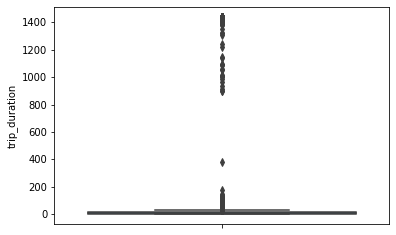

In [129]:
sns.boxplot(y="trip_duration", data =new_df)
plt.show()

From the plot we can see there are are outliers as the plot is skewed. Let us calculate the percentile values ( 0 to 100) to identify those outliers and remvoe them


In [0]:
percentile_tripDuration = new_df.trip_duration.quantile(np.round(np.arange(0.00, 1.01, 0.01), 2))


In [131]:
qValues = np.round(np.arange(0.00, 1.01, 0.1), 2)
for i in qValues:
    print("{}th percentile value of Trip Duration is {}min".format((int(i*100)), percentile_tripDuration[i]))

0th percentile value of Trip Duration is 0.03333333333333333min
10th percentile value of Trip Duration is 3.933333333333333min
20th percentile value of Trip Duration is 5.566666666666666min
30th percentile value of Trip Duration is 7.133333333333334min
40th percentile value of Trip Duration is 8.8min
50th percentile value of Trip Duration is 10.683333333333334min
60th percentile value of Trip Duration is 12.9min
70th percentile value of Trip Duration is 15.683333333333334min
80th percentile value of Trip Duration is 19.6min
90th percentile value of Trip Duration is 26.383333333333333min
100th percentile value of Trip Duration is 1439.2833333333333min


We see that there is a huge difference between 90th percentile and the 100th percentile. Lets find the percentile values between 90th and 100th (90,91,92,... ,100)

In [132]:
for i in range(90,100):
    var =new_df["trip_duration"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

90 percentile value is 26.383333333333333
91 percentile value is 27.466666666666665
92 percentile value is 28.583333333333332
93 percentile value is 29.916666666666668
94 percentile value is 31.55
95 percentile value is 33.55
96 percentile value is 36.43333333333333
97 percentile value is 40.53333333333333
98 percentile value is 47.78333333333333
99 percentile value is 60.78333333333333
100 percentile value is  1439.2833333333333


We see that the value of 100th percentile is 1439.28, which is bizzare for trip duration. According to NYC Taxi and Limousine Commission regulations, the maximum allowed trip duration in a 24hrs interval is 12 hrs. Therefore, removing all outliers that are greater than 720 minutes and less than 1 minute.

In [0]:
new_df = new_df[(new_df.trip_duration>1) & (new_df.trip_duration<720)]

Plotting after the removal of outliers

<IPython.core.display.Javascript object>

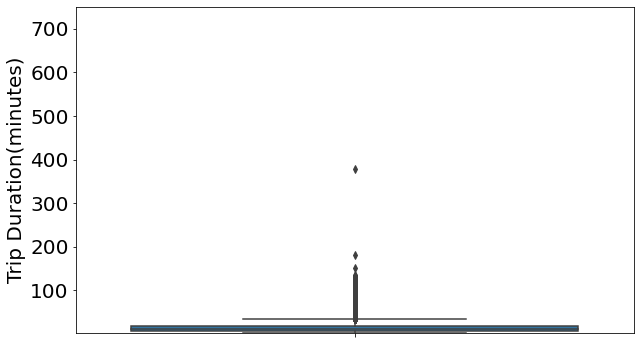

In [134]:
plt.figure(figsize = (10,6))
sns.boxplot("trip_duration", data = new_df, orient = "v")
plt.ylim(ymin = 1, ymax = 750)
plt.tick_params(labelsize = 20)
plt.ylabel("Trip Duration(minutes)", fontsize = 20)
plt.show()

<IPython.core.display.Javascript object>

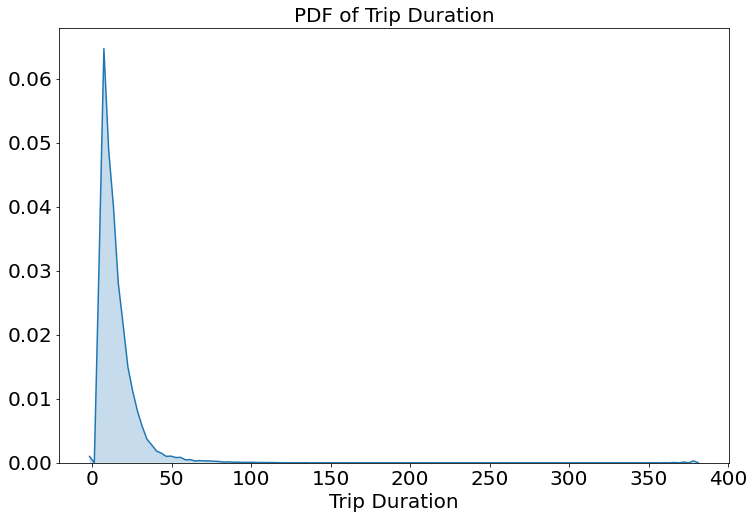

In [135]:
#pdf of trip-times after removing the outliers
plt.figure(figsize = (12,8))
sns.kdeplot(new_df["trip_duration"].values, shade = True, cumulative = False)
plt.tick_params(labelsize = 20)
plt.xlabel("Trip Duration", fontsize = 20)
plt.title("PDF of Trip Duration", fontsize = 20)
plt.show()

 The above plot shows that almost all of the trip durations are approximately less than 100. There are little to no trips with trip durations above 100. 

We have removed all the points where trip duration is more than 12 hrs, removing all the erroneous and outlier points.

#**Speed**

**Speed= Trip Distance / Trip Duration**


Checking for any outliers in the data after trip duration outliers removed

<IPython.core.display.Javascript object>

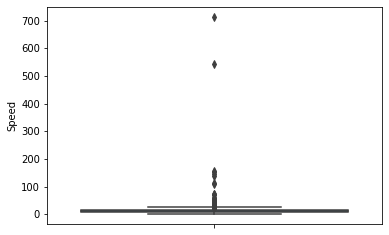

In [136]:
new_df['Speed'] = 60*(new_df['trip_distance']/new_df['trip_duration'])
sns.boxplot(y="Speed", data =new_df)
plt.show()

Just as we did for trip duration, we calcualte percentile values from 0 to 100 to remove errorneous points.


In [0]:
percentile_speed = new_df.speed.quantile(np.round(np.arange(0.00, 1.01, 0.01), 2))

calculating speed values at each percntile 0,10,20,30,40,50,60,70,80,90,100 

In [138]:
qValues = np.round(np.arange(0.00, 1.01, 0.1), 4)
for i in qValues:
    print("{}th percentile value of speed is {}miles/hr".format(int(i*100), percentile_speed[i]))

0th percentile value of speed is 0.064034151547492miles/hr
10th percentile value of speed is 5.578069129916568miles/hr
20th percentile value of speed is 7.199999999999999miles/hr
30th percentile value of speed is 8.645669291338583miles/hr
40th percentile value of speed is 10.074626865671641miles/hr
50th percentile value of speed is 11.55452032490043miles/hr
60th percentile value of speed is 13.15887998559467miles/hr
70th percentile value of speed is 15.046543922096534miles/hr
80th percentile value of speed is 17.40459797427748miles/hr
90th percentile value of speed is 21.4468085106383miles/hr
100th percentile value of speed is 714.2857142857143miles/hr



From the above, we can see that there is a huge difference between 90th percentile and 100th percentile. Now Calculating speed values at each percntile 90,91,92,93,94,95,96,97,98,99,100

In [139]:
qValues = np.round(np.arange(0.91, 1.01, 0.01), 3)
for i in qValues:
    print("{} percentile value of speed is {}miles/hr".format(int(i*100), percentile_speed[i]))

91 percentile value of speed is 22.098232381150957miles/hr
92 percentile value of speed is 22.878545891714733miles/hr
93 percentile value of speed is 23.773584905660375miles/hr
94 percentile value of speed is 24.82758620689655miles/hr
95 percentile value of speed is 26.129050856564234miles/hr
96 percentile value of speed is 27.65859791589766miles/hr
97 percentile value of speed is 29.629745460286195miles/hr
98 percentile value of speed is 32.330161812297746miles/hr
99 percentile value of speed is 36.77539626110759miles/hr
100 percentile value of speed is 714.2857142857143miles/hr


Now again we see a huge difference in percentile between 99th and 100th. Calculating speed values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100. 

In [140]:
for i in np.arange(0.0, 1.0, 0.1):
    var =new_df["Speed"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 36.78865979381443
99.1 percentile value is 37.3035143769968
99.2 percentile value is 37.95978420794507
99.3 percentile value is 38.75704225352113
99.4 percentile value is 39.38775510204082
99.5 percentile value is 40.20779220779221
99.6 percentile value is 41.06024096385542
99.7 percentile value is 42.2680412371134
99.8 percentile value is 43.8
99.9 percentile value is 45.98258539852646
100 percentile value is  714.2857142857143


Now we see that the 100th percentile value of a speed is 714 Million miles/hr which is unusual. Furthermore, 99.9th percentile value of speed is 45 miles/hr. So, we are removing all the data points where speed is greater than 45 miles/hr.

In [0]:
new_df = new_df[(new_df.speed>0) & (new_df.speed<45.31)]

Plotting again after removing erroneous points

<IPython.core.display.Javascript object>

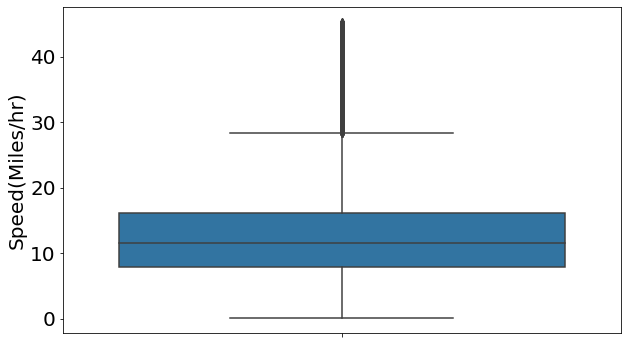

In [142]:
fig = plt.figure(figsize = (10,6))
ax = sns.boxplot("speed", data = new_df, orient = "v")

plt.tick_params(labelsize = 20)
plt.ylabel("Speed(Miles/hr)", fontsize = 20)
plt.show()

Average Speed of cabs in New-York

In [143]:
Average_speed=sum(new_df["Speed"]) / float(len(new_df["Speed"]))
print("Average Speed of Taxis around NYC = "+str(Average_speed))

Average Speed of Taxis around NYC = 12.811521264080907


In [144]:
print("Speed of Taxis around NYC per 10 minutes = "+str(Average_speed/6)+" per 10 minutes.")

Speed of Taxis around NYC per 10 minutes = 2.1352535440134846 per 10 minutes.


**The avg speed in Newyork speed is 12.81miles/hr, so a cab driver can travel 2 miles per 10min on avg**

#**Trip Distance**

Plotting a boxplot to see if there are any outliers in Trip Distance

<IPython.core.display.Javascript object>

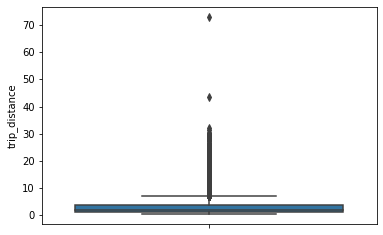

In [145]:
sns.boxplot(y="trip_distance", data =new_df)
plt.show()

Just as we did for trip duration and Speed, we calcualte percentile values 
from 0 to 100 to remove errorneous points.

In [0]:
percentile_tripDistance = new_df.trip_distance.quantile(np.round(np.arange(0.00, 1.01, 0.01), 2))

calculating Trip distance at each percntile 0,10,20,30,40,50,60,70,80,90,100

In [147]:
qValues = np.round(np.arange(0.00, 1.01, 0.1), 2)
for i in qValues:
    print("{}th percentile value of trip distance is {}miles".format(int(i*100), percentile_tripDistance[i]))

0th percentile value of trip distance is 0.1miles
10th percentile value of trip distance is 0.7miles
20th percentile value of trip distance is 0.9miles
30th percentile value of trip distance is 1.17miles
40th percentile value of trip distance is 1.43miles
50th percentile value of trip distance is 1.8miles
60th percentile value of trip distance is 2.21miles
70th percentile value of trip distance is 2.9miles
80th percentile value of trip distance is 4.1miles
90th percentile value of trip distance is 6.9miles
100th percentile value of trip distance is 73.2miles


There is a huge difference between 90th percentile and 100th percentile here as well. Let calculate trip distance values at each percntile 90,91,92,93,94,95,96,97,98,99,100

In [148]:
qValues = np.round(np.arange(0.91, 1.01, 0.01), 3)
for i in qValues:
    print("{} percentile value of trip distance is {}miles".format(int(i*100), percentile_tripDistance[i]))

91 percentile value of trip distance is 7.44miles
92 percentile value of trip distance is 8.09miles
93 percentile value of trip distance is 8.8miles
94 percentile value of trip distance is 9.5miles
95 percentile value of trip distance is 10.37miles
96 percentile value of trip distance is 11.3miles
97 percentile value of trip distance is 12.9miles
98 percentile value of trip distance is 16.63miles
99 percentile value of trip distance is 18.4miles
100 percentile value of trip distance is 73.2miles


Now again we see a huge difference in percentile between 99th and 100th. Calculating trip distance values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100. 

In [149]:
for i in np.arange(0.0, 1.0, 0.1):
    var =new_df["trip_distance"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {} miles".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 18.4 miles
99.1 percentile value is 18.62 miles
99.2 percentile value is 18.86 miles
99.3 percentile value is 19.1 miles
99.4 percentile value is 19.41 miles
99.5 percentile value is 19.79 miles
99.6 percentile value is 20.3 miles
99.7 percentile value is 20.77 miles
99.8 percentile value is 21.35 miles
99.9 percentile value is 22.5 miles
100 percentile value is  73.2


Here, 99.9th percentile of trip distance is 22.5 miles, however, 100th percentile value is 73.2 miles, which is quite high. So, we are removing all the data points where trip distance is greater than 23miles.

In [0]:
new_df = new_df[(new_df.trip_distance>0) & (new_df.trip_distance<23)]

Plotting Trip Distance after removing all outliers

<IPython.core.display.Javascript object>

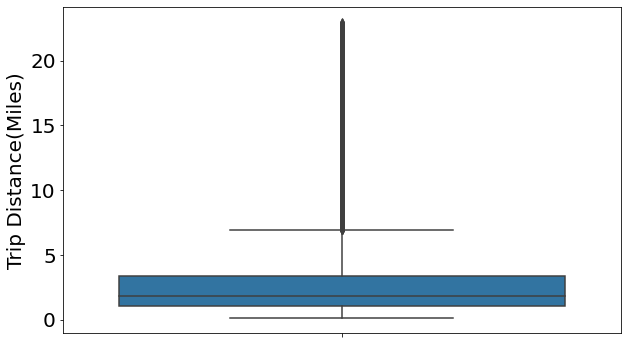

In [151]:
fig = plt.figure(figsize = (10,6))
ax = sns.boxplot("trip_distance", data = new_df, orient = "v")

plt.tick_params(labelsize = 20)
plt.ylabel("Trip Distance(Miles)", fontsize = 20)
plt.show()

#**Total Fare**

Plotting Total Fare, to see if there are any outliers

<IPython.core.display.Javascript object>

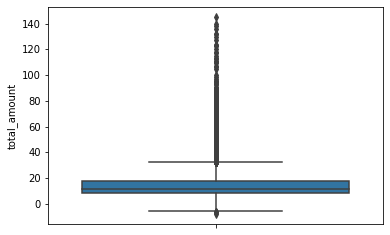

In [152]:
sns.boxplot(y="total_amount", data =new_df)
plt.show()

Just as we did for trip duration and Speed, we calcualte percentile values 
from 0 to 100  for total fare to remove errorneous points.

In [0]:
percentile_totalAmount = new_df.total_amount.quantile(np.round(np.arange(0.00, 1.01, 0.01), 2))

In [154]:
qValues = np.round(np.arange(0.00, 1.01, 0.1), 2)
for i in qValues:
    print("{}th percentile value of trip fare is {}".format(int(i*100), percentile_totalAmount[i]))

0th percentile value of trip fare is -8.3
10th percentile value of trip fare is 6.62
20th percentile value of trip fare is 7.800000000000001
30th percentile value of trip fare is 8.84
40th percentile value of trip fare is 10.3
50th percentile value of trip fare is 11.8
60th percentile value of trip fare is 13.560000000000002
70th percentile value of trip fare is 16.05
80th percentile value of trip fare is 20.16
90th percentile value of trip fare is 28.8
100th percentile value of trip fare is 145.31


In [155]:
 qValues = np.round(np.arange(0.91, 1.01, 0.01), 3)
for i in qValues:
    print("{} percentile value of trip fare is {}".format(int(i*100), percentile_totalAmount[i]))

91 percentile value of trip fare is 30.36
92 percentile value of trip fare is 32.76
93 percentile value of trip fare is 35.3
94 percentile value of trip fare is 38.5
95 percentile value of trip fare is 42.34
96 percentile value of trip fare is 47.23759999999995
97 percentile value of trip fare is 53.5
98 percentile value of trip fare is 59.33839999999968
99 percentile value of trip fare is 68.64
100 percentile value of trip fare is 145.31


In [156]:
quantile_totalAmount = new_df.total_amount.quantile(np.round(np.arange(0.991, 1.001, 0.001), 3))
qValues = np.round(np.arange(0.991, 1.001, 0.001), 3)
for i in qValues:
    print("{} percentile value of trip fare is {}".format((i*100), quantile_totalAmount[i]))

99.1 percentile value of trip fare is 69.99
99.2 percentile value of trip fare is 69.99
99.3 percentile value of trip fare is 70.0
99.4 percentile value of trip fare is 70.01
99.5 percentile value of trip fare is 70.01
99.6 percentile value of trip fare is 70.01
99.7 percentile value of trip fare is 72.3458799999999
99.8 percentile value of trip fare is 72.92
99.9 percentile value of trip fare is 75.84
100.0 percentile value of trip fare is 145.31


 As even the 99.9th percentile value doesnt look like an outlier, as there is not much difference between the 99.8th percentile and 99.9th percentile, let's do some more graphical analyis.
 
 Plot the fare amount only for the last two highest values

<IPython.core.display.Javascript object>

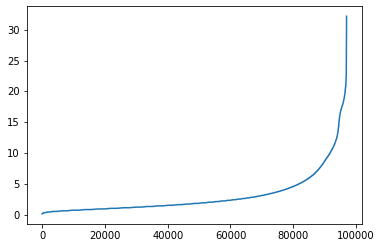

In [157]:
plt.plot(var[:-2])
plt.show()

Plotting last three total fare values

<IPython.core.display.Javascript object>

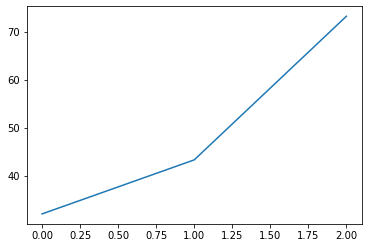

In [158]:
plt.plot(var[-3:])
plt.show()

We can see that there is a very sharp increase in fare values at the second last value. Lets plot last 50 values excluding last two values

<IPython.core.display.Javascript object>

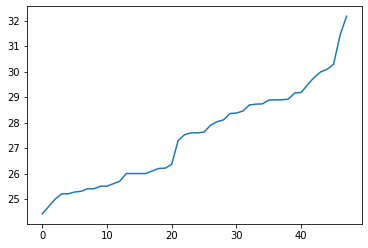

In [159]:
plt.plot(var[-50:-2])
plt.show()

We dont see any drastic changes in this previous graph. Thus, removing all outliers that are above the 99th percentile values

In [0]:
new_df = new_df[(new_df.total_amount>0) & (new_df.total_amount<75.8)]

<IPython.core.display.Javascript object>

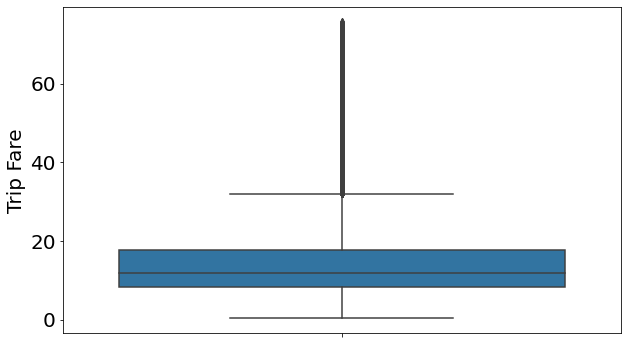

In [161]:
fig = plt.figure(figsize = (10,6))
ax = sns.boxplot("total_amount", data = new_df, orient = "v")

plt.tick_params(labelsize = 20)
plt.ylabel("Trip Fare", fontsize = 20)
plt.show()

# Data Preparation

In [162]:
#trying different cluster sizes to choose the right K in K-means
coords = new_df[['pickup_latitude', 'pickup_longitude']].values
neighbours=[]

def find_min_distance(cluster_centers, cluster_len):
    nice_points = 0
    wrong_points = 0
    less2 = []
    more2 = []
    min_dist=1000
    for i in range(0, cluster_len):
        nice_points = 0
        wrong_points = 0
        for j in range(0, cluster_len):
            if j!=i:
                distance = gpxpy.geo.haversine_distance(cluster_centers[i][0], cluster_centers[i][1],cluster_centers[j][0], cluster_centers[j][1])
                min_dist = min(min_dist,distance/(1.60934*1000))
                if (distance/(1.60934*1000)) <= 2:
                    nice_points +=1
                else:
                    wrong_points += 1
        less2.append(nice_points)
        more2.append(wrong_points)
    neighbours.append(less2)
    print ("On choosing a cluster size of ",cluster_len,"\nAvg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2):", np.ceil(sum(less2)/len(less2)), "\nAvg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2):", np.ceil(sum(more2)/len(more2)),"\nMin inter-cluster distance = ",min_dist,"\n---")

def find_clusters(increment):
    kmeans = MiniBatchKMeans(n_clusters=increment, batch_size=10000,random_state=42).fit(coords)
    new_df['pickup_cluster'] = kmeans.predict(new_df[['pickup_latitude', 'pickup_longitude']])
    cluster_centers = kmeans.cluster_centers_
    cluster_len = len(cluster_centers)
    return cluster_centers, cluster_len

# we need to choose number of clusters so that, there are more number of cluster regions 
#that are close to any cluster center
# and make sure that the minimum inter cluster should not be very less
for increment in range(10, 100, 10):
    cluster_centers, cluster_len = find_clusters(increment)
    find_min_distance(cluster_centers, cluster_len)

On choosing a cluster size of  10 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 2.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 8.0 
Min inter-cluster distance =  1.0103545776908034 
---
On choosing a cluster size of  20 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 4.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 16.0 
Min inter-cluster distance =  0.7381479473094452 
---
On choosing a cluster size of  30 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 7.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 23.0 
Min inter-cluster distance =  0.4146574931146296 
---
On choosing a cluster size of  40 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 9.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 31.0 
Min inter-cluster distance 

### Observation: 

The main objective was to find a optimal min. distance(Which roughly estimates to the radius of a cluster) between the clusters which we got was 40

In [0]:
# if check for the 50 clusters you can observe that there are two clusters with only 0.3 miles apart from each other
# so we choose 40 clusters for solve the further problem

# Getting 40 clusters using the kmeans 
kmeans = MiniBatchKMeans(n_clusters=40, batch_size=10000,random_state=0).fit(coords)
new_df['pickup_cluster'] = kmeans.predict(new_df[['pickup_latitude', 'pickup_longitude']])

##### Plotting the cluster centers:¶


In [164]:
# Plotting the cluster centers on OSM
cluster_centers = kmeans.cluster_centers_
cluster_len = len(cluster_centers)
map_osm = folium.Map(location=[40.734695, -73.990372], tiles='Stamen Toner')
for i in range(cluster_len):
    folium.Marker(list((cluster_centers[i][0],cluster_centers[i][1])), popup=(str(cluster_centers[i][0])+str(cluster_centers[i][1]))).add_to(map_osm)
map_osm

##### Plotting the clusters:¶


<IPython.core.display.Javascript object>

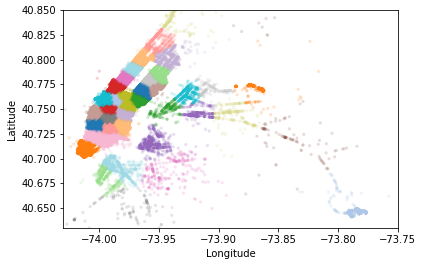

In [165]:
#Visualising the clusters on a map
def plot_clusters(frame):
    city_long_border = (-74.03, -73.75)
    city_lat_border = (40.63, 40.85)
    fig, ax = plt.subplots(ncols=1, nrows=1)
    ax.scatter(frame.pickup_longitude.values[:100000], frame.pickup_latitude.values[:100000], s=10, lw=0,
               c=frame.pickup_cluster.values[:100000], cmap='tab20', alpha=0.2)
    ax.set_xlim(city_long_border)
    ax.set_ylim(city_lat_border)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.show()

plot_clusters(new_df)

# Time Binning

In [0]:

def add_pickup_bins(frame,month,year):
    unix_pickup_times=[i for i in frame['pickup_times'].values]
    unix_times = [[1420070400,1422748800,1425168000,1427846400,1430438400,1433116800],\
                    [1451606400,1454284800,1456790400,1459468800,1462060800,1464739200]]
    
    start_pickup_unix=unix_times[year-2015][month-1]
    # https://www.timeanddate.com/time/zones/est
    # (int((i-start_pickup_unix)/600)+33) : our unix time is in gmt to we are converting it to est
    tenminutewise_binned_unix_pickup_times=[(int((i-start_pickup_unix)/600)+33) for i in unix_pickup_times]
    frame['pickup_bins'] = np.array(tenminutewise_binned_unix_pickup_times)
    return frame

In [0]:
# clustering, making pickup bins and grouping by pickup cluster and pickup bins
new_df['pickup_cluster'] = kmeans.predict(new_df[['pickup_latitude', 'pickup_longitude']])
jan_2015 = add_pickup_bins(new_df,1,2015)
jan_2015_groupby = jan_2015[['pickup_cluster','pickup_bins','trip_distance']].groupby(['pickup_cluster','pickup_bins']).count()

In [168]:
jan_2015.head()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,trip_duration,pickup_times,speed,Speed,pickup_cluster,pickup_bins
0,1,1.10,-73.935516,40.761238,-73.944351,40.754578,7.3,5.800000,1.443658e+09,11.379310,11.379310,36,39345
4,1,3.80,-73.984016,40.755222,-73.959869,40.801323,19.8,16.300000,1.443658e+09,13.987730,13.987730,3,39345
5,1,3.10,-73.975296,40.751396,-73.970924,40.785984,14.8,13.666667,1.443658e+09,13.609756,13.609756,32,39345
6,1,4.50,-73.997078,40.722290,-73.960472,40.761517,17.8,21.366667,1.443658e+09,12.636505,12.636505,26,39345
7,1,0.84,-73.998711,40.734756,-74.003082,40.742546,8.0,5.816667,1.443658e+09,8.664756,8.664756,1,39345


In [169]:
jan_2015_groupby.head()

trip_distance
pickup_cluster pickup_bins               
0              39345                   45
               39346                   40
               39347                   30
               39348                   26
               39349                   23

In [170]:
print("There should be ((24*60)/10)*31 unique 10 minute time bins for the month of January 2015: ", str(len(np.unique(jan_2015["pickup_bins"]))))



There should be ((24*60)/10)*31 unique 10 minute time bins for the month of January 2015:  60


### Data Preparation for Jan 2016

In [171]:
# upto now we cleaned data and prepared data for the month 2015,

# now do the same operations for months Jan, Feb, March of 2016
# 1. get the dataframe which inlcudes only required colums
# 2. adding trip times, speed, unix time stamp of pickup_time
# 4. remove the outliers based on trip_times, speed, trip_duration, total_amount
# 5. add pickup_cluster to each data point
# 6. add pickup_bin (index of 10min intravel to which that trip belongs to)
# 7. group by data, based on 'pickup_cluster' and 'pickuo_bin'

# Data Preparation for the months of Jan,Feb and March 2016
def datapreparation(month,kmeans,month_no,year_no):
    
    print ("Return with trip times..")

    new_df = return_with_trip_times(month)
    
   
    print ("Estimating clusters..")
    new_df['pickup_cluster'] = kmeans.predict(new_df[['pickup_latitude', 'pickup_longitude']])
    #frame_with_durations_outliers_removed_2016['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed_2016[['pickup_latitude', 'pickup_longitude']])

    print ("Final groupbying..")
    final_updated_frame = add_pickup_bins(new_df,month_no,year_no)
    final_groupby_frame = final_updated_frame[['pickup_cluster','pickup_bins','trip_distance']].groupby(['pickup_cluster','pickup_bins']).count()
    
    return final_updated_frame,final_groupby_frame
    
month_jan_2016 = dd.read_csv('2015_sample.csv')

jan_2016_frame,jan_2016_groupby = datapreparation(month_jan_2016,kmeans,1,2016)





0it [00:00, ?it/s]

Return with trip times..


ValueError: ignored